In [132]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [133]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/DIG Historical Data 1_6.csv')

# Nhận thấy tập dữ liệu, ở cột Price giá tiền có dấu phẩy và đang ở dạng string
# Bỏ dấu phẩy
df['Price'] = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df['Price'] = pd.to_numeric(df['Price'])
df = df[::-1]

In [134]:
df1=df.reset_index()['Price']
df1.head()

0    11033.2
1    11457.6
2    12094.1
3    12094.1
4    12200.2
Name: Price, dtype: float64

In [135]:
df1

0       11033.2
1       11457.6
2       12094.1
3       12094.1
4       12200.2
         ...   
1593    27350.0
1594    27850.0
1595    27950.0
1596    27600.0
1597    27750.0
Name: Price, Length: 1598, dtype: float64

In [136]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [137]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [138]:
test_size

319

In [139]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [140]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [141]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [142]:
X_train.shape

(1177, 100, 1)

In [143]:
# 8. Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [144]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
19/19 [==============================] - 2s 18ms/step - loss: 0.0096
Epoch 2/100
19/19 [==============================] - 0s 18ms/step - loss: 0.0013
Epoch 3/100
19/19 [==============================] - 0s 19ms/step - loss: 0.0010
Epoch 4/100
19/19 [==============================] - 0s 20ms/step - loss: 9.2854e-04
Epoch 5/100
19/19 [==============================] - 0s 18ms/step - loss: 7.6099e-04
Epoch 6/100
19/19 [==============================] - 0s 18ms/step - loss: 6.6327e-04
Epoch 7/100
19/19 [==============================] - 0s 19ms/step - loss: 6.2783e-04
Epoch 8/100
19/19 [==============================] - 0s 19ms/step - loss: 5.7276e-04
Epoch 9/100
19/19 [==============================] - 0s 18ms/step - loss: 5.0620e-04
Epoch 10/100
19/19 [==============================] - 0s 20ms/step - loss: 4.9293e-04
Epoch 11/100
19/19 [==============================] - 0s 19ms/step - loss: 5.4015e-04
Epoch 12/100
19/19 [==============================] - 0s 19ms/step - loss: 

In [145]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)


7/7 [==============================] - 0s 7ms/step


In [146]:
# 11. Chuẩn hóa dữ liệu y_pred, y_test
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [147]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 989.8124520400247


In [148]:
# 13. Dự báo 30 ngày tiếp theo (test có 319 ngày)
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=259
i=0
while(i<30):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.15182812 0.15182812 0.15291977 0.15564888 0.15237395 0.15510306
 0.1561947  0.15674052 0.1611071  0.16984026 0.1660195  0.15946964
 0.1611071  0.16820279 0.15510306 0.1561947  0.14909901 0.15674052
 0.15182812 0.15237395 0.15510306 0.15946964 0.16656533 0.16492786
 0.17966506 0.17693595 0.18021088 0.17748177 0.17256937 0.15837799
 0.15783217 0.1561947  0.16274457 0.16001546 0.15564888 0.15510306
 0.16165292 0.15837799 0.15783217 0.16929444 0.17256937 0.18075671
 0.18294    0.17857342 0.18130253 0.19876884 0.20095213 0.207502
 0.20586453 0.21186858 0.207502   0.21186858 0.19986049 0.20422707
 0.207502   0.22169338 0.21896427 0.21405187 0.20968529 0.20913947
 0.2173268  0.22824325 0.2271516  0.2391597  0.23151818 0.21077693
 0.20531871 0.20531871 0.2025896  0.22169338 0.22278503 0.23042654
 0.23042654 0.2391597  0.24079716 0.2440721  0.24953032 0.24843868
 0.2489845  0.23151818 0.2440721  0.23806805 0.22605996 0.22496832
 0.22060174 0.2271516  0.23697641 0.22824325 0.20750

In [149]:
# 13b. Dự báo 60 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_60=[]
n_steps=259
i=0
while(i<60):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i=i+1


0 day input [0.15182812 0.15182812 0.15291977 0.15564888 0.15237395 0.15510306
 0.1561947  0.15674052 0.1611071  0.16984026 0.1660195  0.15946964
 0.1611071  0.16820279 0.15510306 0.1561947  0.14909901 0.15674052
 0.15182812 0.15237395 0.15510306 0.15946964 0.16656533 0.16492786
 0.17966506 0.17693595 0.18021088 0.17748177 0.17256937 0.15837799
 0.15783217 0.1561947  0.16274457 0.16001546 0.15564888 0.15510306
 0.16165292 0.15837799 0.15783217 0.16929444 0.17256937 0.18075671
 0.18294    0.17857342 0.18130253 0.19876884 0.20095213 0.207502
 0.20586453 0.21186858 0.207502   0.21186858 0.19986049 0.20422707
 0.207502   0.22169338 0.21896427 0.21405187 0.20968529 0.20913947
 0.2173268  0.22824325 0.2271516  0.2391597  0.23151818 0.21077693
 0.20531871 0.20531871 0.2025896  0.22169338 0.22278503 0.23042654
 0.23042654 0.2391597  0.24079716 0.2440721  0.24953032 0.24843868
 0.2489845  0.23151818 0.2440721  0.23806805 0.22605996 0.22496832
 0.22060174 0.2271516  0.23697641 0.22824325 0.20750

In [150]:
# 13c. Dự báo 90 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output_90=[]
n_steps=259
i=0
while(i<90):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i=i+1


0 day input [0.15182812 0.15182812 0.15291977 0.15564888 0.15237395 0.15510306
 0.1561947  0.15674052 0.1611071  0.16984026 0.1660195  0.15946964
 0.1611071  0.16820279 0.15510306 0.1561947  0.14909901 0.15674052
 0.15182812 0.15237395 0.15510306 0.15946964 0.16656533 0.16492786
 0.17966506 0.17693595 0.18021088 0.17748177 0.17256937 0.15837799
 0.15783217 0.1561947  0.16274457 0.16001546 0.15564888 0.15510306
 0.16165292 0.15837799 0.15783217 0.16929444 0.17256937 0.18075671
 0.18294    0.17857342 0.18130253 0.19876884 0.20095213 0.207502
 0.20586453 0.21186858 0.207502   0.21186858 0.19986049 0.20422707
 0.207502   0.22169338 0.21896427 0.21405187 0.20968529 0.20913947
 0.2173268  0.22824325 0.2271516  0.2391597  0.23151818 0.21077693
 0.20531871 0.20531871 0.2025896  0.22169338 0.22278503 0.23042654
 0.23042654 0.2391597  0.24079716 0.2440721  0.24953032 0.24843868
 0.2489845  0.23151818 0.2440721  0.23806805 0.22605996 0.22496832
 0.22060174 0.2271516  0.23697641 0.22824325 0.20750

In [151]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size+1-101, step=1)
test_data_index.shape

(219,)

In [152]:
y_pred.shape

(219, 1)

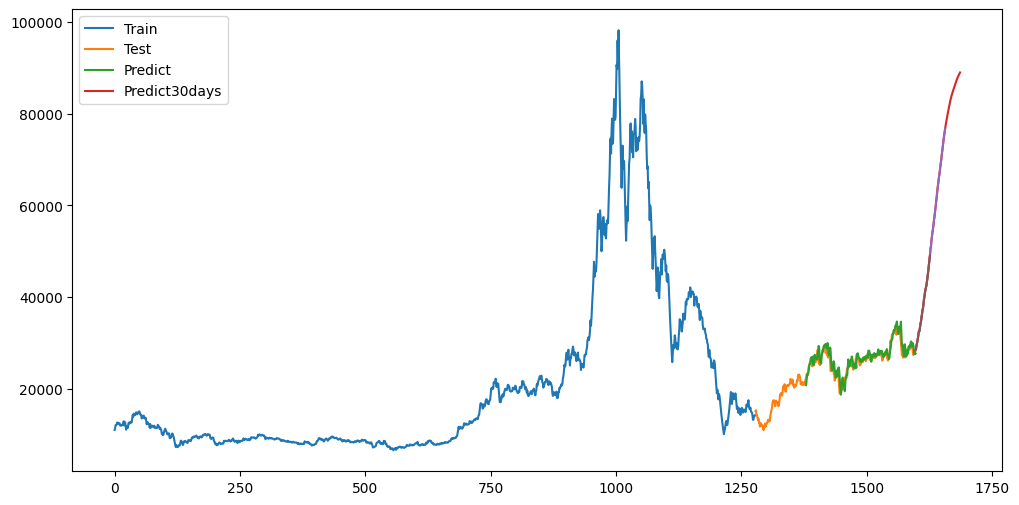

In [153]:
# 14.Vẽ hình
plt.figure(figsize=(12,6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size+1, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size+1, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index_90,scaler.inverse_transform(lst_output_90))

prediect_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index_60,scaler.inverse_transform(lst_output_60))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()